In [47]:
url_1 = "https://odre.opendatasoft.com/explore/embed/dataset/conso-departement-annuelle/table/?disjunctive.libelle_departement&disjunctive.libelle_region&disjunctive.e_operateurs&disjunctive.g_operateurs&refine.annee=2021&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJjb25zb3RvdGFsZSIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6IiM2NmMyYTUifV0sInhBeGlzIjoibGliZWxsZV9kZXBhcnRlbWVudCIsIm1heHBvaW50cyI6NTAsInNvcnQiOiIiLCJjb25maWciOnsiZGF0YXNldCI6ImNvbnNvLWRlcGFydGVtZW50LWFubnVlbGxlIiwib3B0aW9ucyI6eyJkaXNqdW5jdGl2ZS5saWJlbGxlX2RlcGFydGVtZW50Ijp0cnVlLCJkaXNqdW5jdGl2ZS5saWJlbGxlX3JlZ2lvbiI6dHJ1ZSwiZGlzanVuY3RpdmUuZV9vcGVyYXRldXJzIjp0cnVlLCJkaXNqdW5jdGl2ZS5nX29wZXJhdGV1cnMiOnRydWUsInJlZmluZS5hbm5lZSI6IjIwMjEifX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=3,17.56025,53.4375&basemap=jawg.light"
url_2 = "https://www.insee.fr/fr/statistiques/6436484?sommaire=6036904#tableau-figure1_radio1"
url_3 = "https://odre.opendatasoft.com/explore/dataset/temperature-quotidienne-departementale/information/?disjunctive.departement"
url_4 = "https://www.insee.fr/fr/statistiques/6436484?sommaire=6036904#tableau-figure1_radio1"
url_5 = "https://www.observatoire-des-territoires.gouv.fr/outils/cartographie-interactive/#c=indicator&i=insee_rp_hist_1968.part_logt_vacant&s=2020&view=map9"
url_6 = "https://ufe-electricite.fr/watt-the-carte/deploiement-bornes-de-recharge-en-france/dans-les-territoires/"
url_7 = "https://www.carburants.org/borne-electrique/departements/"

In [1]:
# Installation des packages

!pip install -q lxml
!pip install webdriver-manager
!pip install BeautifulSoup4
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install pygeos
!pip install topojson

import requests
import re
import bs4
import lxml
import pandas as pd
import urllib

from urllib import request

In [ ]:
# API

In [ ]:
# On récupere les données de la conso totale d'energie par département, sur le site opendatasoft

In [49]:
# Création de l'url de l'API

root_api_1 = "https://odre.opendatasoft.com"
url_api_1 = root_api_1+"/api/explore/v2.1/catalog/datasets/conso-departement-annuelle/records?select=code_departement%2C%20libelle_departement%2C%20consototale%2C%20geom&where=annee%20%3D%20date%272021%27&order_by=code_departement&limit=99&exclude=libelle_departement%3A971%2C972%2C973%2C974&refine=annee%3A%222021%22"

# Récupération des données

req = requests.get(url_api_1)
conso_energie = req.json()

# Extraire la liste de résultats du dictionnaire
results = conso_energie.get('results', [])
df = pd.DataFrame(results)

# On choisit les variables
table_conso_totale = df[['code_departement', 'libelle_departement', 'consototale','geom']]

# Affichage de la table
table_conso_totale.head()

,code_departement,libelle_departement,consototale,geom
0,01,Ain,9.921409e+06,"{'type': 'Feature', 'geometry': {'coordinates'..."
1,02,Aisne,8.628880e+06,"{'type': 'Feature', 'geometry': {'coordinates'..."
2,2A,Corse-du-Sud,1.008356e+06,"{'type': 'Feature', 'geometry': {'coordinates'..."
3,2B,Haute-Corse,1.003554e+06,"{'type': 'Feature', 'geometry': {'coordinates'..."
4,03,Allier,6.912756e+06,"{'type': 'Feature', 'geometry': {'coordinates'..."


In [ ]:
# On récupere les données de température par département, sur le site opendatasoft

In [ ]:
# Notre jeu de donnée nous donne la température quotidienne dans chaque département. 
# Ne prendre qu'un seul relevé de température augmente énormément la variance de la prédiction si on introduit la température dans le modèle
# On propose donc de récupérer les relevés de températures moyen à chaque 1er du mois, et d'en faire une moyenne 

In [5]:
# On test pour la table des températures du mois de janvier

root_api = "https://odre.opendatasoft.com"
url_api_jan = root_api+"/api/explore/v2.1/catalog/datasets/temperature-quotidienne-departementale/records?select=date_obs%2Ccode_insee_departement%2Cdepartement%2Ctmoy&where=date_obs%3Ddate'2021-01-01'&order_by=code_insee_departement&limit=99&refine=date_obs%3A%222021%22"

req = requests.get(url_api_jan)
temp_jan = req.json()
results = temp_jan.get('results', [])
df = pd.DataFrame(results)
df = df[['date_obs', 'code_insee_departement', 'departement','tmoy']]
df.head()

,date_obs,code_insee_departement,departement,tmoy
0,2021-01-01,01,Ain,1.50
1,2021-01-01,02,Aisne,2.15
2,2021-01-01,2A,Corse-du-Sud,8.71
3,2021-01-01,2B,Haute-Corse,9.12
4,2021-01-01,03,Allier,2.45


In [38]:
# On essaye d'automatiser le processus

liste_url=[]
for i in range(1, 13):
    date_str = f"2021-{i:02d}-01"  # Utilisation de :02d pour formater i avec deux chiffres
    url_api = f"{root_api}/api/explore/v2.1/catalog/datasets/temperature-quotidienne-departementale/records?select=date_obs%2Ccode_insee_departement%2Cdepartement%2Ctmoy&where=date_obs%3Ddate'{date_str}'&order_by=code_insee_departement&limit=99&refine=date_obs%3A%222021%22"
    liste_url.append(url_api)

liste_tab=[]
for url_api in liste_url:
    req = requests.get(url_api)
    temp = req.json()
    results = temp.get('results', [])
    df = pd.DataFrame(results)
    df = df[['date_obs', 'code_insee_departement', 'departement','tmoy']]
    liste_tab.append(df)

# Il reste à fusionner tous les tableaux, et calculer la moyenne des températures moyennes quotidiennes

KeyError: "None of [Index(['date_obs', 'code_insee_departement', 'departement', 'tmoy'], dtype='object')] are in the [columns]"

In [54]:
# Webscrapping

In [ ]:
# Code département, département et population

In [18]:
# Nous avons besoin de scraper la donnée "population" sur chaque page Wikipédia des départements, et pour cela, nous devons obtenir les URL de chaque page. 
# Ainsi, nous créons une liste qui recense tous les URL nécessaires pour accéder à chaque page Wikipédia et extraire la donnée de population.

url_dep = "https://fr.wikipedia.org/wiki/D%C3%A9partement_fran%C3%A7ais"
text_dep = request.urlopen(url_dep).read()
page_dep = bs4.BeautifulSoup(text_dep, 'lxml')
tableau_dep = page_dep.find('div', {'class':'colonnes'})
lignes_dep = tableau_dep.find_all('li')

list_url=[]
for i in range(len(lignes_dep)):
    if re.search(r'href="([^"]*)"', str(lignes_dep[i])).group(1) not in ["#cite_note-collectivitésOM-178",'/wiki/Guadeloupe','/wiki/La_R%C3%A9union'] :
        num_dep = lignes_dep[i].find('code').text.strip()
        list_url.append(["https://fr.wikipedia.org"+re.search(r'href="([^"]*)"', str(lignes_dep[i])).group(1),num_dep])

In [19]:
# Nous automatisons le webscraping d'une page Wikipédia, et chaque résultat est stocké dans un dictionnaire.

dico_dep = dict()
k=1
for url in list_url:
    text = request.urlopen(url[0]).read()
    page = bs4.BeautifulSoup(text, 'lxml')
    tableau = page.find('table',{'class':'infobox_v2 noarchive'})
    tableau_body = tableau.find('tbody')
    lignes = tableau_body.find_all('tr')

    # On webscrapp le nom du département
    
    nom_dep_html = lignes[0].find('td')
    nom_dep_elements = [item for item in nom_dep_html.contents if item.name != 'small'] # On retire les balises <small> qui correpondent aux sous-titres des départements (parfois traduction en breton)
    nom_dep_nouveau_html = bs4.BeautifulSoup('', 'lxml')
    nom_dep_nouveau_html.extend(nom_dep_elements)
    nom_dep_texte = nom_dep_nouveau_html.text.strip()
    nom_dep = re.sub(r'\([^)]*\)', '', nom_dep_texte)

    # On définie le numéro du département
    
    num_dep = url[1]

    # On webscrapp la population du département
    
    for ligne in lignes:
        cols1 = ligne.find_all('th')
        cols2 = ligne.find_all('td')
        cols = [ele.text.strip() for ele in cols1]+[elem.text.strip() for elem in cols2]
        if cols[0]=='Population' or cols[0]=='Populationmunicipale':
            population = re.sub(r'hab.*', '', cols[1])
    dico_dep[num_dep] = {'nom_dep': nom_dep, 'population': population}


In [20]:
# On transforme le dictionnaire en base de données

data_dep = pd.DataFrame.from_dict(dico_dep,orient='index').reset_index()
data_dep = data_dep.rename(columns={'index' : 'Numéro','nom_dep':'Nom','population':'Population'}) 

In [22]:
# On visualise la base de donnée

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data_dep.head()

,Numéro,Nom,Population
0,01,Ain,657 856
1,02,Aisne,529 374
2,03,Allier,335 628
3,04,Alpes-de-Haute-Provence,165 451
4,05,Hautes-Alpes,140 605


In [249]:
# Test pour récupérer la population sur une page wikipédia

# On récupère l'url de la page wikipédia et on importe le texte HTML de la page

url_Loire_Atlantique = "https://fr.wikipedia.org/wiki/Loire-Atlantique"
text_Loire_Atlantique = request.urlopen(url_Loire_Atlantique).read()

In [250]:
# On recherche de manière efficace les balises de la page
population_Loire_Atlantique = 0
page_Loire_Atlantique = bs4.BeautifulSoup(text_Loire_Atlantique, 'lxml')

# On récupère le tableau souhaité
tableau_Loire_Atlantique = page_Loire_Atlantique.find('table',{'class':'infobox_v2 noarchive'})

# On extrait le corps du tableau
tableau_Loire_Atlantique_body = tableau_Loire_Atlantique.find('tbody')

# On extrait toutes les lignes
lignes = tableau_Loire_Atlantique_body.find_all('tr')


#On affiche uniquement le texte et on supprime le code (avec la fonction .text.strip) et on extrait la ligne population du tableau
for ligne in lignes:
    cols1 = ligne.find_all('th')
    cols2 = ligne.find_all('td')
    cols = [ele.text.strip() for ele in cols1]+[elem.text.strip() for elem in cols2]
    if cols[0]=='Population':
        population_Loire_Atlantique = cols[1]

print(population_Loire_Atlantique)

1 445 171 hab. (2020)


In [ ]:
# Webscrapping du niveau de vie

In [28]:
text = request.urlopen("https://www.insee.fr/fr/statistiques/6436484?sommaire=6036904#tableau-figure1_radio1").read()
page = bs4.BeautifulSoup(text, 'lxml')
tableau = page.find('table',{'class':'tableau-produit'})
tableau_body = tableau.find('tbody')
lignes = tableau_body.find_all('tr')

In [42]:
dico_niveau_vie={}
for ligne in lignes:
    nom_dep = ligne.find('th').text.strip()
    niveau_vie_dep = ligne.find('td').text.strip()
    dico_niveau_vie[nom_dep] = {'Niveau de Vie': niveau_vie_dep}

tableau_niveau_vie = pd.DataFrame.from_dict(dico_niveau_vie,orient='index').reset_index()
tableau_niveau_vie = tableau_niveau_vie.rename(columns={'index':'Nom'}) 
tableau_niveau_vie.head()

,Nom,Niveau de Vie
0,Ain,23 490
1,Aisne,19 880
2,Allier,20 570
3,Alpes-Maritimes,22 300
4,Alpes-de-Haute-Provence,20 690


In [55]:
# Webscrapping des logements vacants

text_logements_vacants = request.urlopen(url_5).read()
page_logements_vacants = bs4.BeautifulSoup(text_logements_vacants, 'lxml')
tableau_logements_vacants = page_logements_vacants.find('table', {'id': 'tm_datatable'})
print(tableau_logements_vacants)
## A partir d'ici, pas sûr d'avoir récuperer la bonne partie du code HTML qui code le tableau



None


In [51]:
print(page_logements_vacants)

In [53]:
text_logements_vacants = request.urlopen(url_5).read()
page_logements_vacants = bs4.BeautifulSoup(text_logements_vacants, 'lxml')
print(page_logements_vacants)

In [ ]:
#########################################################################################################################

In [ ]:
############################################ COMMUNES ###################################################################

In [ ]:
#########################################################################################################################

In [ ]:
# Récupération de la consommation d'énergie

In [36]:
# url = https://www.data.gouv.fr/fr/datasets/consommation-annuelle-delectricite-et-gaz-par-commune-et-par-secteur-dactivite/
import pandas as pd

table_conso = pd.read_csv('conso_energie.csv',sep=';')
table_conso.head()

/tmp/ipykernel_760/1596900801.py:4: DtypeWarning: Columns (6,14,24,25,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  table_conso = pd.read_csv('conso_energie.csv',sep=';')


,operateur,annee,filiere,consoa,pdla,nombre_maille_secretisees_a,indquala,consoi,pdli,nombre_maille_secretisees_i,...,libelle_commune,code_epci,libelle_epci,code_departement,libelle_departement,code_region,libelle_region,id_filiere,consototale,code_postal
0,GRDF,2021,Gaz,0.0,0,0,0.0,0.00000,0,1,...,Armeau,248900334,CA du Grand Sénonais,89,Yonne,27.0,Bourgogne-Franche-Comté,200.0,2317.51553,89500
1,GRDF,2021,Gaz,0.0,0,0,0.0,0.00000,0,1,...,Branches,200067114,CA de l'Auxerrois,89,Yonne,27.0,Bourgogne-Franche-Comté,200.0,1905.29787,89113
2,GRDF,2021,Gaz,0.0,0,0,0.0,1895.35634,9,0,...,Brienon-sur-Armançon,200067304,CC Serein et Armance,89,Yonne,27.0,Bourgogne-Franche-Comté,200.0,16756.07274,89210/89210
3,GRDF,2021,Gaz,0.0,0,0,0.0,0.00000,0,0,...,Brion,248900938,CC du Jovinien,89,Yonne,27.0,Bourgogne-Franche-Comté,200.0,1696.15670,89400
4,GRDF,2021,Gaz,0.0,0,1,0.0,0.00000,0,0,...,La Celle-Saint-Cyr,248900938,CC du Jovinien,89,Yonne,27.0,Bourgogne-Franche-Comté,200.0,4395.90677,89116


In [ ]:
# Récupération de la population

In [6]:
from urllib import request
from bs4 import BeautifulSoup

url_communes = "https://fr.wikipedia.org/wiki/Listes_des_communes_de_France"
text_communes = request.urlopen(url_communes).read().decode('utf-8')
page_communes = BeautifulSoup(text_communes, 'html.parser')
tableau_communes = page_communes.find('table', {'class': 'wikitable'})
tableau_communes = tableau_communes.find('tbody')
lignes_communes = tableau_communes.find_all('tr')
lignes_communes = lignes_communes[:-13]

# Liste pour stocker les contenus après "a href"
liste_url_communes = []

# Parcourir chaque ligne dans lignes_communes
for ligne in lignes_communes:
    # Trouver toutes les balises <td> dans la ligne
    td_tags = ligne.find_all('td')

    if len(td_tags) >= 3:
        if td_tags[-3].text.strip() != '75':
            derniere_td = td_tags[-1]
            a_tag = derniere_td.find('a')
            if a_tag:
                contenu_apres_href = a_tag.get('href')
                liste_url_communes.append(contenu_apres_href)

In [7]:
dico_communes = {}
liste_code_communes = []

for url in liste_url_communes:
    text = request.urlopen("https://fr.wikipedia.org" + url).read().decode('utf-8')
    page = BeautifulSoup(text, 'html.parser')  # Utilisez html.parser au lieu de lxml
    tableau = page.find('table', {'class': 'wikitable sortable titre-en-couleur'})
    tableau = tableau.find('tbody')
    lignes = tableau.find_all('tr')
    lignes.pop(0)
    lignes.pop(-1)

    for ligne in lignes:
        donnees = ligne.find_all('td')
        code_insee = donnees[1].text.strip()
        liste_code_communes.append(code_insee)
        pop_commune = donnees[-3].text.strip()
        dico_communes[code_insee] = pop_commune


In [35]:
tableau_pop_communes = pd.DataFrame.from_dict(dico_communes,orient='index').reset_index()
tableau_pop_communes = tableau_pop_communes.rename(columns={'index':'Code commune'}) 
tableau_pop_communes

,Code commune,0
0,01053,41 681 (2020)
1,01001,806 (2020)
2,01002,262 (2020)
3,01004,14 288 (2020)
4,01005,1 782 (2020)
...,...,...
34807,84147,3 295 (2020)
34808,84148,1 273 (2020)
34809,84149,1 727 (2020)
34810,84150,1 929 (2020)


In [ ]:
# Récupération de la température

In [34]:
# Test de récupération pour une commune
import pandas as pd

root_api = "https://public.opendatasoft.com"
url = root_api + "/api/explore/v2.1/catalog/datasets/donnees-synop-essentielles-omm/records?select=codegeo%2C%20tc%2C%20latitude%2C%20longitude&where=codegeo%3D%2297213%22&limit=99 "

req = requests.get(url)
temp = req.json()
results = temp.get('results', [])
df = pd.DataFrame(results)
df

,codegeo,tc,latitude,longitude
0,97213,28.2,14.595333,-60.995667
1,97213,24.7,14.595333,-60.995667
2,97213,25.6,14.595333,-60.995667
3,97213,27.5,14.595333,-60.995667
4,97213,23.5,14.595333,-60.995667
...,...,...,...,...
94,97213,32.1,14.595333,-60.995667
95,97213,29.9,14.595333,-60.995667
96,97213,29.7,14.595333,-60.995667
97,97213,26.1,14.595333,-60.995667


In [ ]:
# On récupère les données de températures pour chaque commune

In [ ]:
import pandas as pd
import requests

# Dictionnaire pour stocker les moyennes de température par commune
dico_temp_communes = {}

root_api = "https://public.opendatasoft.com"

# Boucle sur chaque codegeo
for codegeo in liste_code_communes:
    # Construire l'URL avec le codegeo actuel
    url = f"{root_api}/api/explore/v2.1/catalog/datasets/donnees-synop-essentielles-omm/records?select=codegeo%2C%20tc%2C%20latitude%2C%20longitude&where=codegeo%3D%22{codegeo}%22&limit=99"

    # Récupérer les données depuis l'API
    req = requests.get(url)
    temp = req.json()
    results = temp.get('results', [])
    
    # Créer un DataFrame avec les résultats
    df = pd.DataFrame(results)
    
    # Vérifier si la colonne 'tc' existe dans le DataFrame
    if 'tc' in df.columns:
        # Calculer la moyenne de la colonne 'tc'
        moyenne = round(df['tc'].mean(), 2)
        
        # Ajouter la moyenne au dictionnaire avec le codegeo comme clé
        dico_temp_communes[codegeo] = moyenne
    else:
        print(f"La colonne 'tc' est absente pour le codegeo {codegeo}")

# Afficher le dictionnaire final
print(dico_temp_communes)

In [ ]:
# On se rends compte qu'on a plein de données manquantes, on associe à chaque commune, la température du département, en faisant l'hypothèse que la température est homogène dans un département

In [ ]:
# On récupère les données de températures de chaque département

In [33]:
# URL de base et structure de l'URL de l'API
root_api = "https://odre.opendatasoft.com"
base_url = "/api/explore/v2.1/catalog/datasets/temperature-quotidienne-departementale/records"
base_query = "?select=date_obs%2Ccode_insee_departement%2Cdepartement%2Ctmoy&order_by=code_insee_departement&limit=99&refine=date_obs%3A%222021%22"

# Collecte des données pour chaque mois
df_list = []
for i in range(1, 13):
    date_str = f"2021-{i:02d}-01"
    url_api = f"{root_api}{base_url}{base_query}&where=date_obs%3Ddate'{date_str}'"
    req = requests.get(url_api)
    temp = req.json()
    results = temp.get('results', [])
    df = pd.DataFrame(results)
    if not df.empty:
        df = df[['date_obs', 'code_insee_departement', 'departement','tmoy']]
        df_list.append(df)

# Fusionner tous les DataFrames en un seul
df_final = pd.concat(df_list)

# Calcul de la moyenne des températures par code et nom de département
table_temperatures = df_final.groupby(['code_insee_departement', 'departement'])['tmoy'].mean().reset_index()

# Affichage du DataFrame final
table_temperatures.head()

,code_insee_departement,departement,tmoy
0,01,Ain,11.875000
1,02,Aisne,11.237500
2,03,Allier,12.441667
3,04,Alpes-de-Haute-Provence,13.133333
4,05,Hautes-Alpes,11.062500


In [ ]:
# On associe à chaque commune la température moyenne calculée du département

In [32]:
import pandas as pd

# Création d'un DataFrame à partir de la liste des codes INSEE
data_communes = {'code_commune': liste_code_communes}
df_communes = pd.DataFrame(data_communes)

# Exécution d'une jointure entre les deux DataFrames
resultat = pd.merge(df_communes, table_temperatures, left_on=df_communes['code_commune'].str[:2], right_on=table_temperatures['code_insee_departement'])

# Afficher le résultat
resultat[['code_commune', 'tmoy']]

,code_commune,tmoy
0,01053,11.875000
1,01001,11.875000
2,01002,11.875000
3,01004,11.875000
4,01005,11.875000
...,...,...
34808,84147,14.166667
34809,84148,14.166667
34810,84149,14.166667
34811,84150,14.166667


In [ ]:
# Récupération des données du nombres d'entreprises

In [31]:
# url = https://www.observatoire-des-territoires.gouv.fr/outils/cartographie-interactive/#c=indicator&f=TOT&i=demo_ent_sect.ent_tot&s=2021&view=map59
import pandas as pd

table_nb_entr_indus = pd.read_csv('table_nb_entr_com.csv',sep=';')
table_nb_entr_indus.head()

,Code,Libellé,Nombre d'entreprises par secteurs d'activité 2021,Nombre d'entreprises par secteurs d'activité 2021.1
0,1001,L'Abergement-Clémenciat,41,2
1,1002,L'Abergement-de-Varey,18,3
2,1004,Ambérieu-en-Bugey,1097,54
3,1005,Ambérieux-en-Dombes,133,12
4,1006,Ambléon,7,0


In [ ]:
# Récupération du niveau de vie

In [30]:

# url = https://www.data.gouv.fr/fr/datasets/niveau-de-vie-des-francais-par-commune/
import pandas as pd

table_niveau_vie = pd.read_csv('niveau_vie_com.csv',sep=';')
table_niveau_vie.head()

,CODGEO,LIBGEO,MED14
0,1001,L'Abergement-Clémenciat,"21576,7"
1,1002,L'Abergement-de-Varey,"21672,9"
2,1004,Ambérieu-en-Bugey,"19756,1"
3,1005,Ambérieux-en-Dombes,"23204,8"
4,1006,Ambléon,"22157,5"


In [ ]:
# Récupération logements vacants

In [29]:
# url = https://www.data.gouv.fr/fr/datasets/niveau-de-vie-des-francais-par-commune/
import pandas as pd

# Remplacez 'logement_vacants_com.csv' par le chemin complet de votre fichier CSV
table_logements_vacants = pd.read_csv('logement_vacants_com.csv', sep=';', encoding='ISO-8859-1')
table_logements_vacants

/tmp/ipykernel_760/2153706320.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  table_logements_vacants = pd.read_csv('logement_vacants_com.csv', sep=';', encoding='ISO-8859-1')


,codgeo,libgeo,an,part_logt_vacant
0,1001,L'Abergement-Clémenciat,1968,"15,5"
1,1001,L'Abergement-Clémenciat,1975,"12,6"
2,1001,L'Abergement-Clémenciat,1982,"9,1"
3,1001,L'Abergement-Clémenciat,1990,"4,6"
4,1001,L'Abergement-Clémenciat,1999,"3,1"
...,...,...,...,...
279555,97617,Tsingoni,1990,NaN
279556,97617,Tsingoni,1999,NaN
279557,97617,Tsingoni,2009,NaN
279558,97617,Tsingoni,2014,NaN


ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


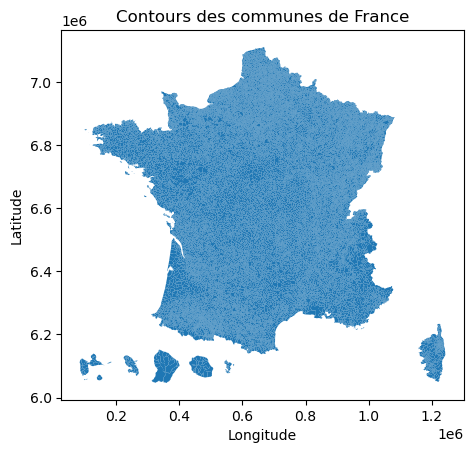

In [3]:
!pip install geopandas matplotlib

import geopandas as gpd
import matplotlib.pyplot as plt

# Charger les données géospatiales à partir du fichier GeoJSON
communes = gpd.read_file('Carte_com.json')

# Afficher le contour des communes
communes.plot()
plt.title('Contours des communes de France')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [5]:
# Charger les données géospatiales à partir du fichier SHP
donnees_spatiales = gpd.read_file('communes-20220101.shp')

# Afficher le contour des entités géospatiales
donnees_spatiales.plot()
plt.title('Contour des entités géospatiales')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


DriverError: Unable to open communes-20220101.shx or communes-20220101.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [ ]:
https://data.statistiques.developpement-durable.gouv.fr/dido/api/v1/datasets?page=1&pageSize=all&orderBy=title&text=un%20texte%20%C3%A0%20rechercher&topics=%C3%89nergie&organizations=6273cf1eed00fe6d6695e146%2C6273cf1eed00fe6d6695e147&granularities=fr%3Acommune&frequencies=daily&minLastModified=2022-01-01&maxLastModified=2022-12-31&temporalCoverageStart=2020-01-01&temporalCoverageEnd=2022-12-31


In [11]:
import requests
import pandas as pd
# Remplacez l'URL ci-dessous par l'URL réelle de votre API
url_api = "https://data.ademe.fr/data-fair/api/v1/datasets/dpe-france/lines?page=1&after=1&size=12&select=%2A&highlight=&q_mode=simple"

# Effectuer la requête HTTP
response = requests.get(url_api)

# Vérifier si la requête a réussi (statut 200)
if response.status_code == 200:
    # Charger les données JSON dans un dictionnaire
    data_dict = response.json()
    lines_data = data_dict.get("data", [])

    # Convertir la liste de lignes en DataFrame
    df = pd.DataFrame(lines_data)

    # Afficher le DataFrame
    print(df)
    # Afficher le DataFrame
df

Empty DataFrame
Columns: []
Index: []


""
